# *Titanic* Data Analysis
The following is an exploration and analysis of data regarding passengers of *RMS Titanic*, specifically a non-predictave examination of which factors may have been related to passenger survival when the ship sank on 15 April 1912.

## Question: which factors affected passenger survival?

We start by importing passenger data:

In [1]:
import pandas as pd
passengers = pd.read_csv('titanic_data.csv')

There were 2,224 aboard the ship when it sank; this data is just a sample of 891 of those passengers.

In [2]:
len(passengers)

891

Let's look at the data to see what we have to work with:

In [3]:
passengers.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


This data was originally taken from https://www.kaggle.com/c/titanic/data, and we can review that to explain the less descriptive column names.

**Survived**: 0 if the passenger died, 1 if the passenger survived. This is the variable we are most interested in examining.

**Pclass**: Passenger class, a proxy for socioeconomic status (SES).

**Age**: Age of the passenger. Estimated for some passengers, represented by "xx.5"

**SibSp**: Number of siblings or spouses who were also passengers on the Titanic.

**Parch**: Number of parents or children who were also passengers on the Titanic.

**Ticket**: Ticket number. Unclear if this can be used in meaninful ways.

**Fare**: Passenger fare, in 1912 dollars.

**Cabin**: Cabin, when known. Note that this is unknown for most passengers.

**Embarked**: PPort of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

## Data Wrangling
We can start by turning non-numeric column data into numbers that are easier to examine statistically. 'Sex' is an obvious candidate. After all, wasn't the saying "women and children first" regarding how to priritize space in the lifeboats? [[source](https://en.wikipedia.org/wiki/Women_and_children_first)]

In [4]:
passengers['Sex'] = passengers['Sex'].apply(lambda s: {'male':0, 'female':1}[s])

Because we can't group or rank unique attributes such as *PassengerId*, *Ticket*, *Cabin*, or *Name*, they aren't easily amenible to standard stastical examination and we can exclude these from our analysis. NB: *PassengerId* is numeric and sortable, but is a serial number applied to a random sampling of the data by Kaggle, so any correlation with it an any other attribute should be spurious.

In [5]:
del passengers['PassengerId']
del passengers['Ticket']
del passengers['Cabin']
del passengers['Name']

At this point we can do a cursory examination of the numeric columns we have to see which variables might correlate with passenger survival.

In [6]:
passengers.corr()['Survived']

Survived    1.000000
Pclass     -0.338481
Sex         0.543351
Age        -0.077221
SibSp      -0.035322
Parch       0.081629
Fare        0.257307
Name: Survived, dtype: float64

'Survived' correlates perfectly with itself, and can of course be ignored. After that, it seems like *Sex* has the highest correlation (0.54), followed by *Pclass* (-0.34) and *Fare* (0.26). Other factors seem to correlate weakly, though it's possible that there is noise or confounding factors we could filter out.

### Survival rate by sex

Sex is very simple to directly investigate:

In [7]:
passengers.groupby('Sex')['Survived'].describe()

Sex       
0    count    577.000000
     mean       0.188908
     std        0.391775
     min        0.000000
     25%        0.000000
     50%        0.000000
     75%        0.000000
     max        1.000000
1    count    314.000000
     mean       0.742038
     std        0.438211
     min        0.000000
     25%        0.000000
     50%        1.000000
     75%        1.000000
     max        1.000000
dtype: float64

There is a large standard deviation, but sex seems to be very highly correlated with survival. Visually:

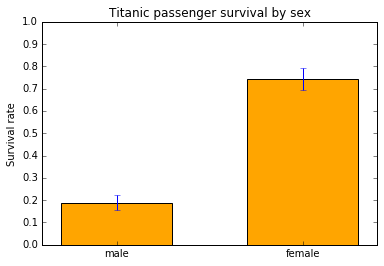

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.api as sms

survival = passengers.groupby('Sex')['Survived']
def error_bar(group, bound):
    return abs(survival.get_group(group).mean() - sms.DescrStatsW(survival.get_group(group)).tconfint_mean()[bound])
survival_err = [[error_bar(0, 0), error_bar(1, 0)], [error_bar(0, 1), error_bar(1, 1)]]

fig, ax = plt.subplots()

ax.bar(np.arange(2), survival.mean(), width=0.6, color='orange', align='center')
ax.errorbar(np.arange(2), survival.mean(), fmt='none', yerr=survival_err)
plt.xticks(np.arange(2), ('male', 'female'))
plt.yticks(np.arange(11)*0.1)
plt.ylabel('Survival rate')
plt.title('Titanic passenger survival by sex')

Even though the standard deviations are high, there are enough data points that our estimated 95% confidence intervals (shown as the error bars in the above plot) are quite tight. We can directly examine whether this could be a chance occurence or whether this is a "true" correlation by using *Fisher's exact test* to evalute the null hypothesis that the survival rates are the same for both sexes.

In [9]:
import scipy

def correlation_table(sex, survived):
    if survived == 1:
        return survival.get_group(sex).sum()
    return len(survival.get_group(sex)) - survival.get_group(sex).sum()

table = [[correlation_table(0,0), correlation_table(0,1)], [correlation_table(1,0), correlation_table(1,1)]]
oddsration, pvalue = scipy.stats.fisher_exact(table)
pvalue

6.4639215645818617e-60

Normally we would accept significance at $p<0.5$, and find it very compelling if we find $p<0.01$. In this case, we find $p<10^{-59}$, a mind-bogglingly small value, and while we can't point directly to causation, we can be assured that there is a high, large and real correlation between the survial rates of passengers on the Titanic and their sex.

### Survival rate by passenger class

The next most promising variable to examine is *Pclass*, or the passenger class (in modern times, first, business and coach). We might for example hypothesize that upper-class passengers had higher survival rates, either because they were prioritized during the escape efforts or because they were lodged closer to the top deck and thus less likely to be trapped.

In [10]:
passengers.groupby('Pclass')['Survived'].mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

That seems to match our hypothesis. Visually:

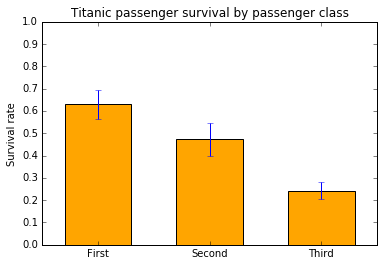

In [11]:
survival = passengers.groupby('Pclass')['Survived']
def error_bar(group, bound):
    return abs(survival.get_group(group).mean() - sms.DescrStatsW(survival.get_group(group)).tconfint_mean()[bound])
survival_err = [[error_bar(i, j) for i in range(1, len(survival) + 1)] for j in (0, 1)]

fig, ax = plt.subplots()

ax.bar(np.arange(len(survival)), survival.mean(), width=0.6, color='orange', align='center')
ax.errorbar(np.arange(len(survival)), survival.mean(), fmt='none', yerr=survival_err)
plt.xticks(np.arange(len(survival)), ('First', 'Second', 'Third'))
plt.yticks(np.arange(11)*0.1)
plt.ylabel('Survival rate')
plt.title('Titanic passenger survival by passenger class')

Indeed, relatively few passengers had a first-class ticket, but those that did had far better survival rates than passengers in the much more common third-class cabins.

Perhaps more interestingly, how does this show up when controlling for sex?

In [12]:
passengers.groupby(['Sex','Pclass']).mean()

Survived        Age     SibSp     Parch        Fare
Sex Pclass                                                     
0   1       0.368852  41.281386  0.311475  0.278689   67.226127
    2       0.157407  30.740707  0.342593  0.222222   19.741782
    3       0.135447  26.507589  0.498559  0.224784   12.661633
1   1       0.968085  34.611765  0.553191  0.457447  106.125798
    2       0.921053  28.722973  0.486842  0.605263   21.970121
    3       0.500000  21.750000  0.895833  0.798611   16.118810

Interesting. *Pclass* is predictive of survival rates, but how it does so varies by sex. There's very little
difference between the survival rates of second and third class men, but first class men survived more than twice as often as either of them. On the other hand, almost all of the first and second class women passengers survived (upwards of 95%), but third class women did half as well---still better, however, than even first class men passengers.

Let's examine this visually:

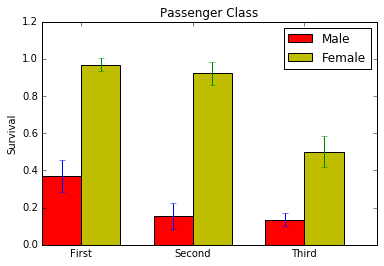

In [29]:
survival = passengers[passengers['Sex'] == 0].groupby(['Pclass'])['Survived']
male_means = survival.mean()
male_err = [[error_bar(i, j) for i in range(1, len(survival) + 1)] for j in (0, 1)]

N = len(survival)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, male_means, width, color='r', yerr=male_err)

survival = passengers[passengers['Sex'] == 1].groupby(['Pclass'])['Survived']
female_means = survival.mean()
female_err = [[error_bar(i, j) for i in range(1, len(survival) + 1)] for j in (0, 1)]

rects2 = ax.bar(ind + width, female_means, width, color='y', yerr=female_err)

# add some text for labels, title and axes ticks
ax.set_ylabel('Survival')
ax.set_title('Passenger Class')
ax.set_xticks(ind + width)
ax.set_xticklabels(('First', 'Second', 'Third'))

ax.legend((rects1[0], rects2[0]), ('Male', 'Female'))

plt.show()

When examining the data broken down by *Pclass* and *Sex*, I noticed that *Age* also appeared to have an interesting relationship with *Sex* (entirely separate from survival rates). Let's dig into that visually. Note that we will first filter out NaNs from the *Age* column, since we can't estimate or guess these.

In [61]:
aged_passengers = passengers[np.isfinite(passengers['Age'])]
aged_passengers.groupby('Sex').mean()

,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,
0,0.205298,2.335541,30.726645,0.439294,0.271523,27.268836
1,0.754789,2.065134,27.915709,0.639847,0.708812,47.582759


The means appear to differ only by $\approx 3$ years; interestingly, this *also* seems to indicate that sex had an effect on the number of siblings, spouses, children and parents aboard (perhaps men more often traveled alone?) as well as on *Fare*. Curious. Why would female passengers pay almost 75% more for their fares?

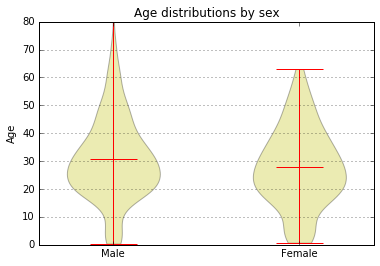

In [55]:
fig, ax = plt.subplots()

all_data = [aged_passengers[aged_passengers['Sex'] == s]['Age'] for s in (0, 1)]

# plot violin plot
ax.violinplot(all_data, showmeans=True, showmedians=False)
ax.set_title('Age distributions by sex')

ax.yaxis.grid(True)
ax.set_xticks([y+1 for y in range(len(all_data))])
ax.set_ylabel('Age')

# add x-tick labels
ax.set_xticklabels(('Male', 'Female'))
plt.show()

Those don't look as different as I might have imagined. It seems like there are more young female passengers than young male passengers, and the maximum age of the male passengers is higher. The means appear to be slightly but not dramatically different. It would make sense to use a non-parametric test to actually examine population variations. Below, we use the Mann-Whitney U-test.

In [58]:
male = aged_passengers[aged_passengers['Sex'] == 0]['Age']
female = aged_passengers[aged_passengers['Sex'] == 1]['Age']

scipy.stats.mannwhitneyu(male, female).pvalue

0.026087746884279634

Statistically different, but not overwhelmingly so.

## Conclusion

This was just an inital inspection of the Titanic data, and our conclusions are more informative of future investigative efforts than they are thoroughly sound.

*Sex* appeared to have a significant effect on passenger *Survival*, with both wildly different populations means for different sexes and a very low p-value. The effect held while controlling for *Pclass*, but different passenger classes were found to have different survival rates that also depended on sex, and in general, passengers in a higher class had better survival rates.

*Sex* and *Age* were correlated at a statistically significant rate, but the actual difference of means was small ($<3$ years). We didn't investigate further, but it seems as if *Sex* was likely correlated with most of the other columns of data as well.

Note that these conclusions are *observational descriptions*, and don't necessarily predict facts for the other pasengers who were aboard the Titanic nor other ships, nor do they actually give us casual information. We might hazard a guess that female passengers survived more because they were priorized during the effort to abandon the ship---and reported history supports this hypothesis---but the data as-is can't actually tell us why, so that remains a guess even if we can factually state that there were large statistical differences in the survival rates of men and women.